In [1]:
from matplotlib import *
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics.pairwise import pairwise_distances


## create fake populations and distances

In [2]:

# Sample Data: Population of locations (Replace with WorldPop data)
locations = ['A', 'B', 'C', 'D', 'E']
population = [10000, 5000, 20000, 15000, 12000]
distances = {
    ('A', 'B'): 10, ('A', 'C'): 30, ('A', 'D'): 50, ('A', 'E'): 70,
    ('B', 'C'): 20, ('B', 'D'): 40, ('B', 'E'): 60,
    ('C', 'D'): 15, ('C', 'E'): 35,
    ('D', 'E'): 25
}

# Convert to DataFrame
pop_df = pd.DataFrame({'Location': locations, 'Population': population})
dist_df = pd.DataFrame([(k[0], k[1], v) for k, v in distances.items()], columns=['From', 'To', 'Distance'])


## Build your Gravity Model 

The number of trips occurring from i to j are inversely proportional to the distance that divides i and j and where masses of origin and destination are the respective populations.


The form with the power law deterrence functions is written as:  
$\Large T_{ij} = K \frac{m_i^\alpha m_j^\beta}{d^\gamma}$

The form with the exponential deterrence functions is written as:  
$\Large T_{ij} = K m_i^\alpha m_j^\beta e^{-d/d_0}$


where $\alpha$ and $\beta$ modulate the attractiveness of masses  
$\gamma$ regulates the decay of the gravity force with distance  
and $d_0$ represents the typical distance travelled by individuals

### create a table containing the two gravity models predicted flows between i and j

In [3]:

def gravity_model(pop_df, dist_df, alpha=1, beta=1):
    flows = []
    for _, row in dist_df.iterrows():
        pop_i = pop_df.loc[pop_df['Location'] == row['From'], 'Population'].values[0]
        pop_j = pop_df.loc[pop_df['Location'] == row['To'], 'Population'].values[0]
        distance = row['Distance']
        flow = (pop_i ** alpha * pop_j ** beta) / (distance ** 2)
        flows.append(flow)
    dist_df['Gravity Flow'] = flows
    return dist_df

def gravity_model_exp(pop_df, dist_df, alpha=1, beta=1):
    flows = []
    for _, row in dist_df.iterrows():
        pop_i = pop_df.loc[pop_df['Location'] == row['From'], 'Population'].values[0]
        pop_j = pop_df.loc[pop_df['Location'] == row['To'], 'Population'].values[0]
        distance = row['Distance']
        flow = (pop_i ** alpha * pop_j ** beta) * np.exp(-distance/d0)
        flows.append(flow)
    dist_df['Gravity Flow Exp'] = flows
    return dist_df

alpha=1
beta=1
d0=5000
gravity_results = gravity_model(pop_df, dist_df)
gravity_results = gravity_model_exp(pop_df, dist_df)

print("Gravity Model Results:")
print(gravity_results)


Gravity Model Results:
  From To  Distance  Gravity Flow  Gravity Flow Exp
0    A  B        10  5.000000e+05      4.990010e+07
1    A  C        30  2.222222e+05      1.988036e+08
2    A  D        50  6.000000e+04      1.485075e+08
3    A  E        70  2.448980e+04      1.183317e+08
4    B  C        20  2.500000e+05      9.960080e+07
5    B  D        40  4.687500e+04      7.440239e+07
6    B  E        60  1.666667e+04      5.928430e+07
7    C  D        15  1.333333e+06      2.991013e+08
8    C  E        35  1.959184e+05      2.383259e+08
9    D  E        25  2.880000e+05      1.791022e+08


## Build your Radiation Model

The number of trips occurring from i to j is controlled by the formula


$\Large T_{ij} = T_i \frac{(m_i m_j)}{(m_i + s_{ij})(m_i + m_j + s_{ij})}$




where $m_i$ and $m_j$ are the populations of i and j and $s_{ij}$ is the intervening population


### Add the radiation model predicted flows to the table of results

In [4]:

def radiation_model(pop_df, dist_df):
    flows = []
    for _, row in dist_df.iterrows():
        pop_i = pop_df.loc[pop_df['Location'] == row['From'], 'Population'].values[0]
        pop_j = pop_df.loc[pop_df['Location'] == row['To'], 'Population'].values[0]
        distance = dist_df[(dist_df.From==row['From'])&(dist_df.To==row['To'])].Distance
        loc_s = set(dist_df[dist_df.From==row['From']].groupby(['To']).filter(lambda x:(x['Distance'].max()<distance)&(x['Distance'].max()>0))['To'].values)
        pop_s = pop_df[pop_df.Location.isin(loc_s)]['Population'].sum()
        print(pop_s)
        flow = pop_i * (pop_i * pop_j / ((pop_i + pop_s) * (pop_i + pop_j + pop_s)))
        flows.append(flow)
    dist_df['Radiation Flow'] = flows
    return dist_df

radiation_results = radiation_model(pop_df, dist_df)
print("\nRadiation Model Results:")
print(radiation_results)


0
5000
25000
40000
0
20000
35000
0
15000
0

Radiation Model Results:
  From To  Distance  Gravity Flow  Gravity Flow Exp  Radiation Flow
0    A  B        10  5.000000e+05      4.990010e+07     3333.333333
1    A  C        30  2.222222e+05      1.988036e+08     3809.523810
2    A  D        50  6.000000e+04      1.485075e+08      857.142857
3    A  E        70  2.448980e+04      1.183317e+08      387.096774
4    B  C        20  2.500000e+05      9.960080e+07     4000.000000
5    B  D        40  4.687500e+04      7.440239e+07      375.000000
6    B  E        60  1.666667e+04      5.928430e+07      144.230769
7    C  D        15  1.333333e+06      2.991013e+08     8571.428571
8    C  E        35  1.959184e+05      2.383259e+08     2917.933131
9    D  E        25  2.880000e+05      1.791022e+08     6666.666667


## Now model the mobility between Italian provinces  
population from https://demo.istat.it/app/?i=POS 

In [42]:
pops = pd.read_csv('../data/id_provinces_it.csv').drop(['Unnamed: 0'],axis=1)
#things happen... 'NA' stands for Napoli (Naples), but geopandas reads it as nan...
pops = pops.fillna('NA')
pops.set_index('COD_PROV',inplace=True)
pops.head()

,SIGLA,DEN_PCM
COD_PROV,,
1,TO,Torino
2,VC,Vercelli
3,NO,Novara
4,CN,Cuneo
5,AT,Asti


In [44]:
pop_prov = pd.read_csv('../data/Popolazione residente.csv')
pop_prov = pop_prov[['Codice provincia', 'Totale']]
pop_prov.set_index('Codice provincia', inplace=True)
pop_prov.head()

,Totale
Codice provincia,
1,2207873
2,165878
3,364478
4,581676
5,207310


In [45]:
populations = pops.merge(pop_prov, how='left', left_on='COD_PROV', right_on='Codice provincia')
#populations.to_csv('population_provinces.csv')
len(populations)

107

In [46]:
places = populations.SIGLA

Get mobility data from https://data.humdata.org/dataset/covid-19-mobility-italy   
paper https://www.nature.com/articles/s41597-020-00575-2   
mobility matrix, already normalized across columns => outflows sum to 1 for each patch

In [54]:
OD = pd.read_csv('../data/od_matrix_daily_flows_norm_full_2020_01_18_2020_06_26.csv')

#from dataframe, create matrix filling empty positions
P = OD.sort_values(['p1','p2']).groupby(['p1','p2']).sum().unstack().fillna(0)
P = P['2020-01-29'].to_numpy()

<div class="alert alert-block alert-warning" style="font-size:120%">

**ATTENTION**  
the mobility matrix was computed on population samples resulting from a data collection that is not representative of the local populations  

we need to project these probabilities into real provinces population, to do this we will:

* project probabilities to total trips following census population
* make it symmetric, assume all trips in one direction are also round trips

</div>

In [85]:
# retrieve total flows from origins
p2 = P*np.array(populations.Totale)

# the original matrix is directed, make it symmetric or populations will be mixed!
OD_matrix = np.round((p2+p2.T)/2)

download shapefile of italian provinces from https://public.opendatasoft.com/explore/dataset/georef-italy-provincia/information/

(1263367.6894823099, 2361994.6851407625, 3869344.226223284, 5284646.808183195)

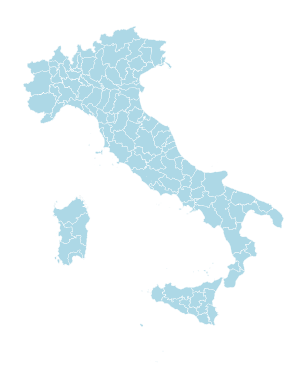

In [64]:
map_prov = gpd.read_file('../data/georef-italy-provincia/georef-italy-provincia-millesime.shp')
map_prov = map_prov[['prov_sigla','geometry']]
map_prov = map_prov.to_crs(epsg=3003)
map_prov.plot(edgecolor='w',facecolor='lightblue',lw=.2)
plt.axis('off')

In [65]:
#reorder to match order of data
map_prov = map_prov.set_index("prov_sigla")
map_prov = map_prov.reindex(places)
map_prov = map_prov.reset_index()


In [66]:
map_prov.head()

,SIGLA,geometry
0,TO,"POLYGON ((1413895.601 5049112.702, 1413847.945..."
1,VC,"POLYGON ((1412952.07 5086507.78, 1413034.71 50..."
2,NO,"POLYGON ((1449479.28 5068983.792, 1449603.407 ..."
3,CN,"MULTIPOLYGON (((1378953.658 4958558.311, 13791..."
4,AT,"POLYGON ((1441342.497 4929852.335, 1441348.092..."


remember how we computed the centroid for polygons in geopandas?

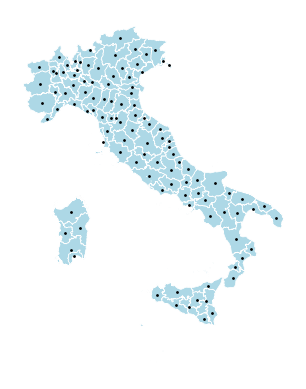

In [67]:
map_prov['centroid'] = map_prov.centroid
ax=map_prov.plot( linewidth=.5, edgecolor='w', color='lightblue')
map_prov['centroid'].plot(color='k',ax=ax, markersize=1)
ax.axis('off')
plt.show()

In [68]:
italy_prov = map_prov.merge(populations, how='left', left_on='SIGLA', right_on='SIGLA')
italy_prov.head()

,SIGLA,geometry,centroid,DEN_PCM,Totale
0,TO,"POLYGON ((1413895.601 5049112.702, 1413847.945...",POINT (1377242.348 5000194),Torino,2207873
1,VC,"POLYGON ((1412952.07 5086507.78, 1413034.71 50...",POINT (1438337.932 5041500.224),Vercelli,165878
2,NO,"POLYGON ((1449479.28 5068983.792, 1449603.407 ...",POINT (1465227.191 5045648.772),Novara,364478
3,CN,"MULTIPOLYGON (((1378953.658 4958558.311, 13791...",POINT (1387719.007 4925839),Cuneo,581676
4,AT,"POLYGON ((1441342.497 4929852.335, 1441348.092...",POINT (1435769.513 4969660.386),Asti,207310


In [69]:
italy_prov['centroid_x'] = italy_prov['centroid'].apply(lambda x: x.x)
italy_prov['centroid_y'] = italy_prov['centroid'].apply(lambda x: x.y)

compute distances in meters (we're in epsg 3003, Monte Mario)

In [71]:
locations = italy_prov.SIGLA.tolist()
population = italy_prov['Totale'].tolist()

distances = pairwise_distances(italy_prov[['centroid_x','centroid_y']], metric='euclidean')


In [72]:
np.diag(distances)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [73]:
# Convert to DataFrame
pop_df = pd.DataFrame({'Location': locations, 'Population': population})
pop_dict = pop_df.set_index('Location')['Population'].to_dict()
dist_df = pd.DataFrame(distances, index=locations, columns=locations)

In [90]:
dist_df.head()

,TO,VC,NO,CN,AT,AL,AO,IM,SV,GE,...,LO,RN,PO,KR,VV,VB,MB,FM,BT,SU
TO,0.000000,73748.725071,99032.665905,75089.456812,66013.109417,102811.221561,65229.743778,136288.448979,117221.967135,152920.096827,...,168526.694235,419755.514546,319119.082993,1.028038e+06,1.023837e+06,126497.664528,153312.559156,541176.533567,836162.599867,646728.436027
VC,73748.725071,0.000000,27207.402222,126252.898587,71885.736913,85145.944878,68126.505712,178153.464645,138214.050435,137629.880137,...,112084.292779,379061.349971,287434.895103,1.007824e+06,1.010117e+06,63671.523009,83592.355456,505787.760994,806570.397572,679564.334085
NO,99032.665905,27207.402222,0.000000,142695.130485,81498.403249,82132.054676,92816.959352,189100.504980,143948.022077,129687.544049,...,88367.069252,357334.982859,269153.344129,9.908553e+05,9.951722e+05,60748.114485,56388.379831,485146.004543,787034.220056,681986.652807
CN,75089.456812,126252.898587,142695.130485,0.000000,65032.030337,93807.359104,140150.346515,61499.890856,59974.485308,122032.323105,...,178309.246185,392481.785328,286040.263043,9.753584e+05,9.664621e+05,188693.977741,184408.339360,505655.093827,792183.895002,571719.411574
AT,66013.109417,71885.736913,81498.403249,65032.030337,0.000000,38109.154298,113623.128013,107727.851719,66713.667303,87009.159807,...,116550.691175,354795.447588,253236.035636,9.632039e+05,9.604298e+05,135247.513087,119402.296502,475326.490007,770212.040591,608252.452104


In [75]:
distance_df = dist_df.unstack().reset_index()
distance_df = distance_df.rename(columns={'level_0':'origin','level_1':'destination',0:'distance'})

In [76]:
distance_df['pop orig'] = distance_df['origin'].apply(lambda x: pop_dict[x])
distance_df['pop dest'] = distance_df['destination'].apply(lambda x: pop_dict[x])

distance_df = distance_df[(distance_df['pop orig']>0) & (distance_df['pop dest']>0)]

### Use your gravity model to generate flows with the WorldPop data

In [165]:

# Gravity Model Function
alpha=1
beta=1
gamma=.4
d0=10000 #meters
def Gravity_pow(x, y, d, alpha, beta, gamma):
    return (x**alpha * y**beta) / (d**gamma)

def Gravity_exp(x, y, d, alpha, beta, d0):
    return x**alpha * y**beta * np.exp(-d/d0)

distance_df['gravity model pow'] = distance_df[['pop orig','pop dest','distance']].apply(lambda x: Gravity_pow(x[0],x[1],x[2],alpha,beta,gamma), axis=1)
distance_df['gravity model exp'] = distance_df[['pop orig','pop dest','distance']].apply(lambda x: Gravity_exp(x[0],x[1],x[2],alpha,beta,d0), axis=1)

distance_df.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_23510/1195155690.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance_df['gravity model pow'] = distance_df[['pop orig','pop dest','distance']].apply(lambda x: Gravity_pow(x[0],x[1],x[2],alpha,beta,gamma), axis=1)
/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_23510/1195155690.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return (x**alpha * y**beta) / (d**gamma)
/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_23510/1195155690.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance_df['gravity model e

In [183]:
distance_df.head()

,origin,destination,distance,pop orig,pop dest,gravity model pow,gravity model exp,p_ij pow,p_ij exp
0,TO,TO,0.000000,2207873,2207873,NaN,4.874703e+12,NaN,2.207873e+06
1,TO,VC,73748.725071,2207873,165878,4.136767e+09,2.295601e+08,1873.643599,1.039734e+02
2,TO,NO,99032.665905,2207873,364478,8.078561e+09,4.024495e+07,3658.979120,1.822793e+01
3,TO,CN,75089.456812,2207873,581676,1.440203e+10,7.039820e+08,6523.032766,3.188508e+02
4,TO,AT,66013.109417,2207873,207310,5.404335e+09,6.218440e+08,2447.756293,2.816484e+02


In [228]:
res_df = distance_df.groupby(['origin','destination'])['gravity model pow'].sum().to_frame()
res_df = res_df.reindex(level=0, labels=places).reindex(level=1, labels=places).unstack()
res_matrix = res_df.to_numpy()
res_matrix

array([[0.00000000e+00, 4.13676711e+09, 8.07856121e+09, ...,
        1.87765136e+09, 3.55543818e+09, 3.44544549e+09],
       [4.13676711e+09, 0.00000000e+00, 1.01761917e+09, ...,
        1.44936548e+08, 2.70998706e+08, 2.53779558e+08],
       [8.07856121e+09, 1.01761917e+09, 0.00000000e+00, ...,
        3.23816359e+08, 6.01324933e+08, 5.56827976e+08],
       ...,
       [1.87765136e+09, 1.44936548e+08, 3.23816359e+08, ...,
        0.00000000e+00, 4.03470776e+08, 2.75669350e+08],
       [3.55543818e+09, 2.70998706e+08, 6.01324933e+08, ...,
        4.03470776e+08, 0.00000000e+00, 5.88379388e+08],
       [3.44544549e+09, 2.53779558e+08, 5.56827976e+08, ...,
        2.75669350e+08, 5.88379388e+08, 0.00000000e+00]])

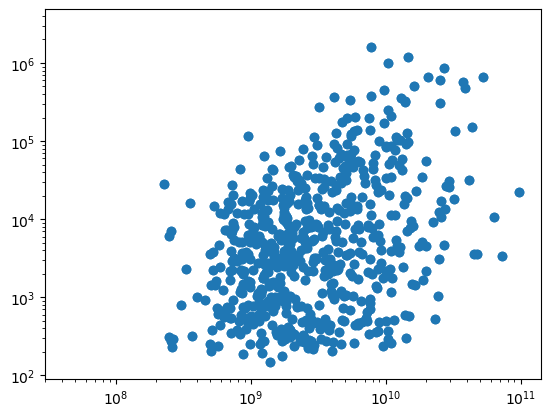

In [229]:
plt.loglog(res_matrix.flatten(),OD_matrix.flatten(),'o', lw=0);


### Use your radiation model to generate flows with the WorldPop data

In [230]:
def get_s(origin,destination):
    df_orig = distance_df[(distance_df.origin==origin)]
    distance = distance_df[(distance_df.origin==origin)&(distance_df.destination==destination)].distance.values[0]
    loc_s = set(df_orig[df_orig['distance']<distance]['destination'].values)
    pop_s = pop_df[pop_df.Location.isin(loc_s)]['Population'].sum()
    return pop_s
        
    
pops_s = []
for i in distance_df.origin.unique():
    print(i)
    for j in distance_df.destination.unique():
        if j>=i:
            pops_s.append([i,j,get_s(i,j)])
            pops_s.append([j,i,get_s(i,j)])

TO
VC
NO
CN
AT
AL
AO
IM
SV
GE
SP
VA
CO
SO
MI
BG
BS
PV
CR
MN
BZ
TN
VR
VI
BL
TV
VE
PD
RO
UD
GO
TS
PC
PR
RE
MO
BO
FE
RA
FC
PU
AN
MC
AP
MS
LU
PT
FI
LI
PI
AR
SI
GR
PG
TR
VT
RI
RM
LT
FR
CE
BN
NA
AV
SA
AQ
TE
PE
CH
CB
FG
BA
TA
BR
LE
PZ
MT
CS
CZ
RC
TP
PA
ME
AG
CL
EN
CT
RG
SR
SS
NU
CA
PN
IS
OR
BI
LC
LO
RN
PO
KR
VV
VB
MB
FM
BT
SU


In [231]:
pop_s = pd.DataFrame(pops_s, columns=['origin','destination','s'])

In [244]:
new_df = pd.merge(
    left=distance_df, 
    right=pop_s,
    how='left',
    left_on=['origin', 'destination'],
    right_on=['origin', 'destination']
)

In [245]:

# Radiation Model Function
def radiation_model(pop_i, pop_j, pop_s):
    return pop_i * (pop_i * pop_j / ((pop_i + pop_s) * (pop_i + pop_j + pop_s)))
        

new_df['Radiation model'] = new_df[['pop orig','pop dest','s']].apply(lambda x: radiation_model(x[0],x[1],x[2]),axis=1)


/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_23510/2206042534.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_df['Radiation model'] = new_df[['pop orig','pop dest','s']].apply(lambda x: radiation_model(x[0],x[1],x[2]),axis=1)


In [246]:
new_df = new_df.groupby(['origin','destination'])['Radiation model'].sum().to_frame()
new_df = new_df.reindex(level=0, labels=places).reindex(level=1, labels=places).unstack()
new_matrix = new_df.to_numpy()


Text(0.5, 0, 'modelled trips')

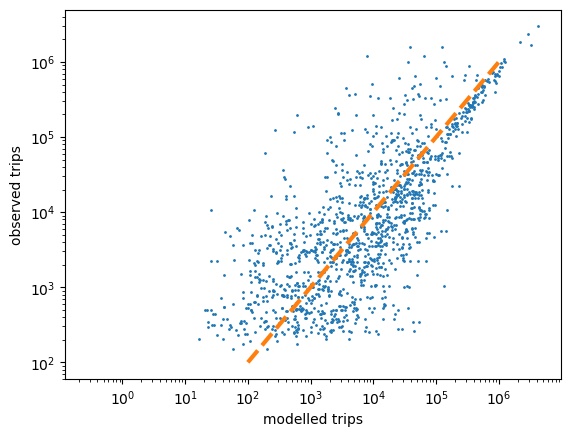

In [252]:
plt.loglog(new_matrix.flatten(),OD_matrix.flatten(),'o', lw=0, markersize=1);
plt.loglog([100,1000000],[100,1000000], lw=3, ls='--')
plt.ylabel('observed trips')
plt.xlabel('modelled trips')